# Introduction to sklearn-onnx


Convert [scikit-learn](https://scikit-learn.org/stable/) models into ONNX.

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = RandomForestClassifier()
clr.fit(X_train, y_train)

RandomForestClassifier()

In [2]:
import numpy as np
from skl2onnx import to_onnx
clr_onnx = to_onnx(clr, X_train.astype(np.float32))

**Part 1 : convert to ONNX**

* [scikit-learn](https://scikit-learn.org/) design, [sklearn-onnx](https://onnx.ai/sklearn-onnx/) design
* Options (black list, white list)
* double, float, sparse

**Part 2 : Custom operators and API**

* Initial API: verbose
* Second API: much more readable
* The missing converter: FunctionTransformer
* Numpy API: python users

**Part 3 : Tools**

* Python Runtime for ONNX
* Writing mathematical function with ONNX such as FFT2D

In [45]:
from jyquickhelper import add_notebook_menu
from IPython.display import Image
add_notebook_menu()

In [38]:
add_notebook_menu?

## Part 1: convert to ONNX


* [scikit-learn](https://scikit-learn.org/) design, [sklearn-onnx](https://onnx.ai/sklearn-onnx/) design
    * simple example
    * ``fit``, ``predict``, ``pipelines``
    * parser, shape calculator, converter
    * package folders
* Options (black list, white list)
    * One opset, one ONNX graph
    * Use custom optimized operator (CDist, Tokenizer)
    * Black list an operator
    * Zipmap
* double, float, sparse
    * scikit-learn, lightgbm are using double, onnx does not support double for all operators
    * cannot replace double by float --> unavoidable discrepancies
    * scikit-learn is using dense and sparse ([OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TfIdfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html))

In [46]:
add_notebook_menu(first_level=2, keep_item=0)

### scikit-learn design: fit, predict, pipelines


In [4]:
import warnings
from pandas import DataFrame
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

dft = DataFrame(X_train, columns=data.feature_names)
dft['Y'] = y_train
dft.head(n=2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Y
0,0.03615,80.0,4.95,0.0,0.411,6.630,23.4,5.1167,4.0,245.0,19.2,396.90,4.70,27.9
1,0.04297,52.5,5.32,0.0,0.405,6.565,22.9,7.3172,6.0,293.0,16.6,371.72,9.51,24.8


The model:
* Normalizes a few continuous columns
* Transforms two columns with categories
* Merges all and trains a linear predictor

**Training**

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ('prep', ColumnTransformer([
        ('scaler', StandardScaler(), [0, 2, 4, 5, 6]),
        ('cat', OneHotEncoder(), [3, 8]),
    ])),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  [0, 2, 4, 5, 6]),
                                                 ('cat', OneHotEncoder(),
                                                  [3, 8])])),
                ('reg', LinearRegression())])

**Prediction**

It calls method ``predict`` for each component of the pipeline

In [6]:
model.predict(X_test)[:3]

array([16.32498174, 17.73875442, 23.76514952])

**Visualization**

In [7]:
from jyquickhelper import RenderJsDot
from mlinsights.plotting import pipeline2dot
dot = pipeline2dot(model, X_train)
RenderJsDot(dot, height="40%", width="40%")

### sklearn-onnx: parser, shape calculator, converter

The conversion happens with one function: [to_onnx](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.to_onnx). It runs:
* the **parsers**: extract the **number of outputs** of every step in the pipeline
* the **shape calculators**: compute the **shapes** of every step in the pipeline
* the converters: **convert** every step in the pipeline and an equivalent ONNX graph

In [8]:
from skl2onnx import to_onnx
from skl2onnx.common.data_types import DoubleTensorType

model_onnx = to_onnx(model, X_train.astype(np.float64))

print(str(model_onnx)[:400])

ir_version: 7
producer_name: "skl2onnx"
producer_version: "1.9.3.dev"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    input: "column_indices"
    output: "extracted_feature_columns"
    name: "ArrayFeatureExtractor"
    op_type: "ArrayFeatureExtractor"
    domain: "ai.onnx.ml"
  }
  node {
    input: "X"
    input: "column_indices1"
    output: "extracted_feat


**Visualization**

In [9]:
%load_ext mlprodict

In [10]:
%onnxview model_onnx --size="8%"

**parser**

0. The main parser calls the parser for the pipeline.
1. The pipeline parser calls the parser of every step.
2. The pipeline of step 1 (ColumnTransformer) calls the parser of every step included in it (recursively).

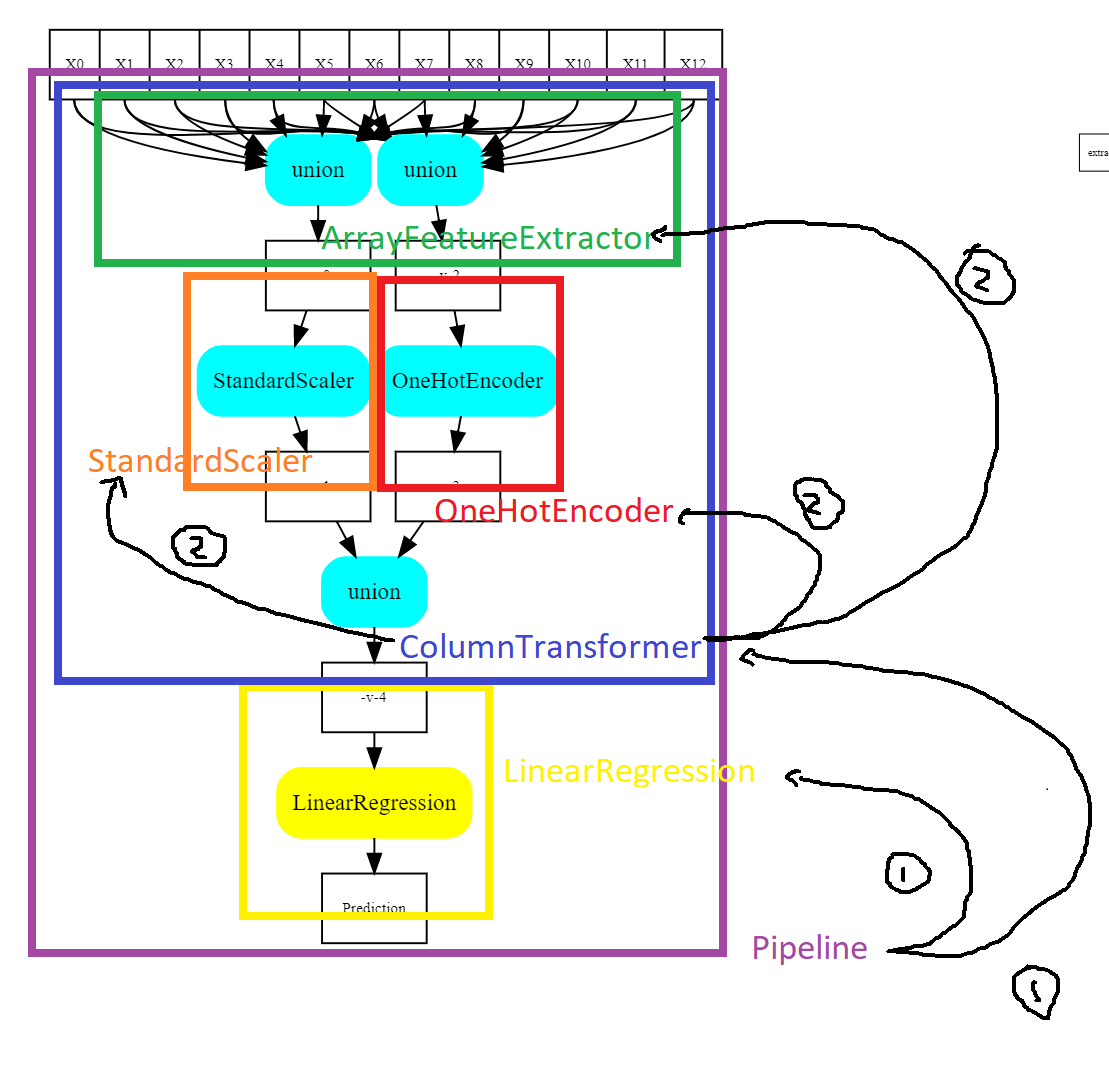

In [11]:
Image('images/pipeskl.png', width=600)

**parser signature**

* Creates an instance of class [Operator](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.common._topology.Operator)
* Fills with [Variable](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.common._topology.Variable) as inputs
* Creates expected output [Variable](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.common._topology.Variable) as outputs
* Returns the outputs (= inputs for next steps)

In [12]:
def parser_example(
        scope,  # namespace (avoids creating duplicating names)
        model, # any scikit-learn model,
        inputs, # known inputs (Variable)
        custom_parsers=None): # custom parser

    step_to_convert = scope.declare_local_operator(alias, model)

    # inputs
    step_to_convert.inputs.append(inputs[0])

    # outputs
    out1 = scope.declare_local_variable('prediction', FloatTensorType())
    step_to_convert.outputs.append(out1)

    # ends
    return step_to_convert.outputs

**Result after parsing**

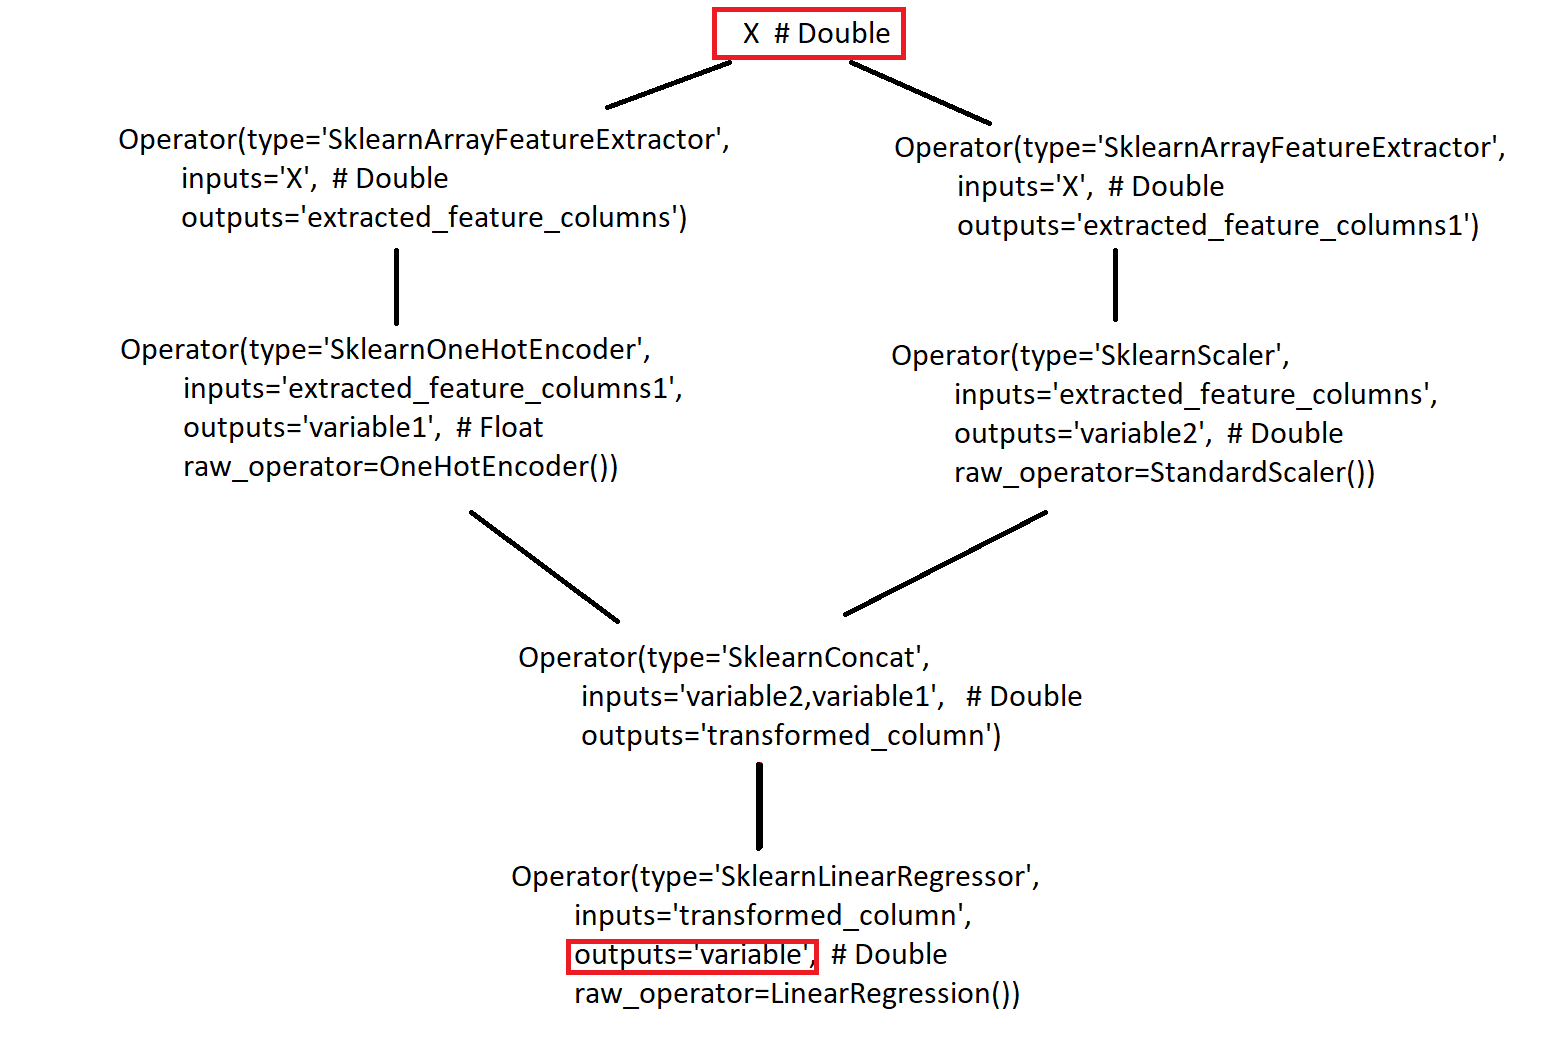

In [13]:
Image('images/op2onx.png', width=800)

**How many parsers?**

* One for each kind of machine learning problem (regressor, classifier, clustering)
* One for each pipeline manipulations ([Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), [UnionFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html).
* One for each model with an option to add more results ('score_samples' in [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.score_samples))
* One main parser to dispatch the calls.

### Topology

Once the parsing is done. The topology handles the conversion of every `Operator`.

The loop: [convert_topology](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/common/_topology.py#L1067).

* Function [to_onnx](http://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.to_onnx) creates a [Topology] (http://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.common._topology.Topology)
* **Iteration 1:** The topology calls shape calculator, converter.
* **Iteration 2:** The converters may declare new operators, they call the parsers (recursively). Return to **iteration 1** until there is no new operator.

**shape calculator signature**

The shape calculator estimates the output size. It can be left unknown if this size cannot be fully inferred (rare): ``FloatTensorType([None, None])``.

example: [KMeans](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/shape_calculators/k_means.py)

In [14]:
def shape_calculator_example(operator):
    op = operator.raw_operator  # the scikit-learn model
    input_type = operator.inputs[0].type.__class__
    N = operator.inputs[0].get_first_dimension()  # usually None for batch prediction
    output_type = input_type([N, op.coef_.shape[1]])
    operator.outputs[0].type = output_type

**converter signature**

example: [KMeans](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/operator_converters/k_means.py)

In [15]:
def decorrelate_transformer_converter(
        scope,  # namespace
        operator,  # (model, inputs, outputs)
        container):   # holds the onnx nodes
    # ...
    pass

**Mapping between scikit-learn and ONNX**

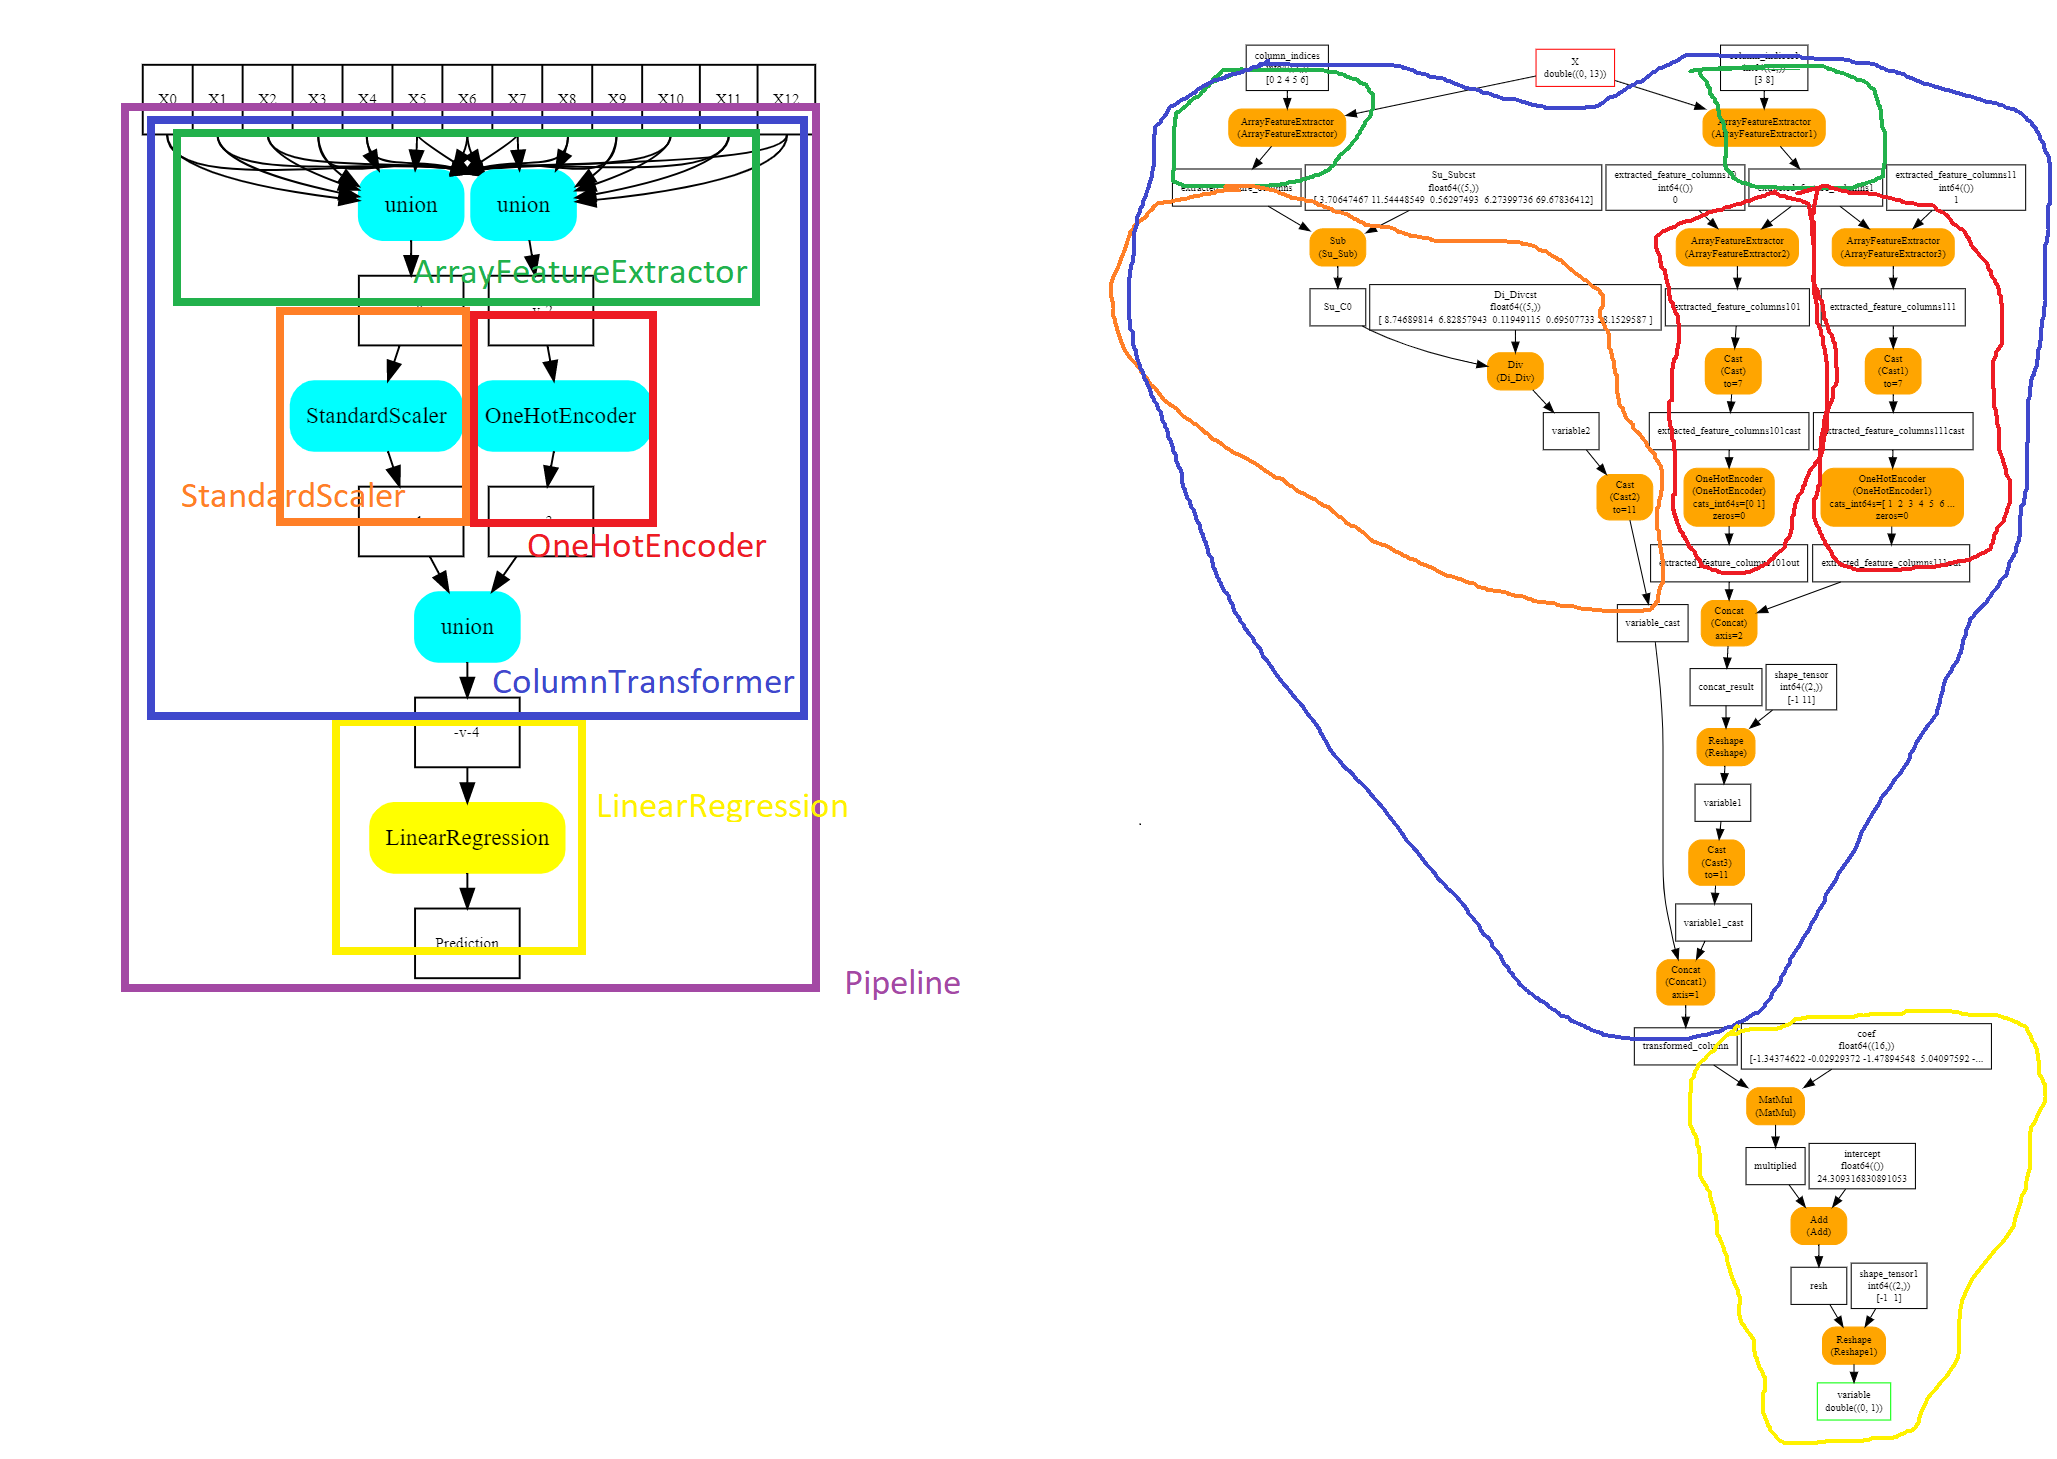

In [16]:
Image('images/pipecolorball.png')

**Final comments on the design**

* The three components (parser, shape_calculator, converter) are overcomplex.
* The converter should be the only part needed.
* The code can be simplified without changing the user API.
    * It needs to move the parsing code into the converter (see [_parse_sklearn_pipeline](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/_parse.py#L242) and [convert_pipeline](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/operator_converters/pipelines.py#L10)).
    * Modify class Topology.

### Registration

A converter must be registered to be called by the topology.

Otherwise, the conversion fails by telling one step cannot be converted.

```
update_registered_converter(
    SklearnModel,   # python class
    "SklearnModel",   # alias
    shape_calculator, converter,
    parser,  # parser is optional if it is a standard model (Classifier, Regressor, ...)
    options=None)   # options are optional but must be declared if any)
```

### Package folders

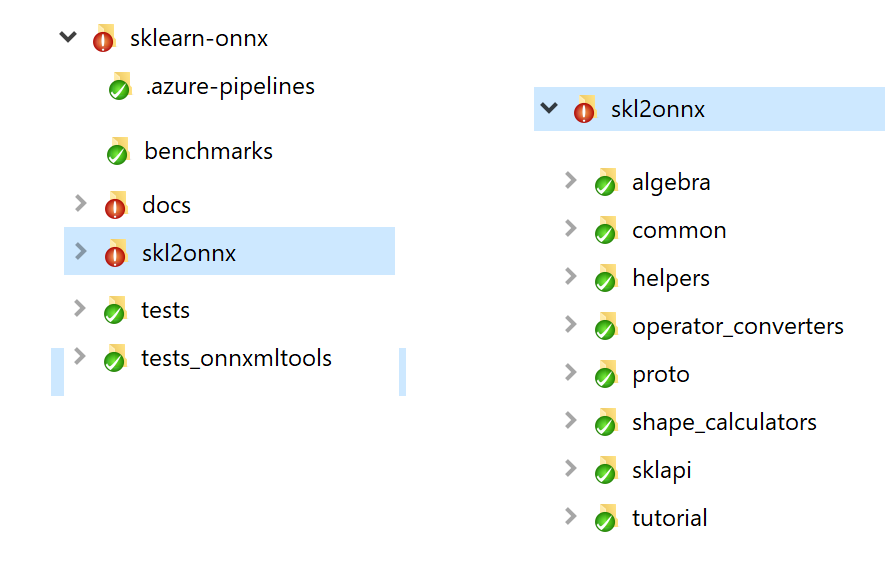

In [34]:
Image('images/folders2.png', width=700)

### Opset, Options

**One model, multiple ONNX graphs**

* Every opset (ONNX version) may change operator signature and introduce new operators.
* Three ways to output probabilities
    * A single tensor ``[N, C]``
    * A list of `N` dictionaries ``{class: probability}`` *(default, historical reasons)*
    * A dictionary ``{class: tensors}`` (requested by a user)

```
to_onnx(model,
        initial_types=...,
        target_opset=14,  # select opset 14 because the runtime does not support higher opset
        options={'zipmap': False})  # select single tensor for probabilities
```

**Option for a specific step in the pipeline**

What if an option only applies on one step, one model, one transformer...

```
pipeline = make_pieline(....)

to_onnx(model,
        initial_types=...,
        target_opset=14,  # select opset 14 because the runtime does not support higher opset
        options={id(pipeline.steps_[0][1]): {'split': 10}})  # select single tensor for probabilities
```

### Why options? option `optim='cdist'`

* Operator CDist is not an ONNX operator
* It can be implemented by operator [Scan](https://github.com/onnx/onnx/blob/master/docs/Operators.md#Scan)

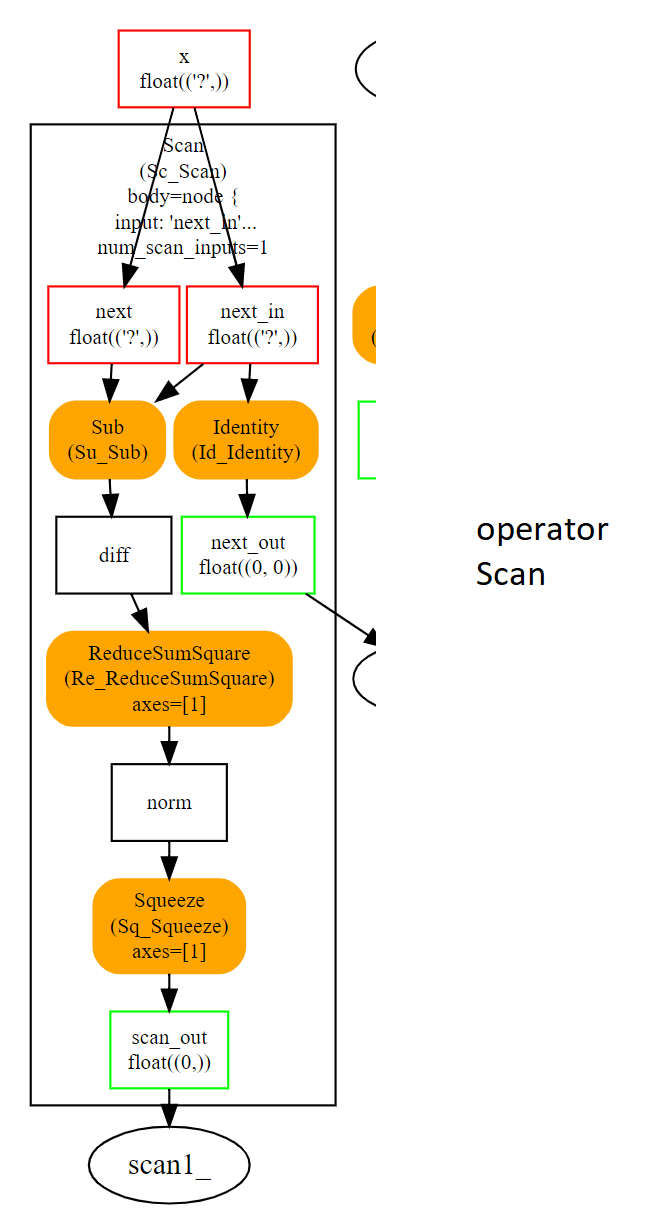

In [35]:
Image("images/cdist.png", width=300)

**CDist vs Scan**

CDist implemented in domain [com.microsoft](https://github.com/microsoft/onnxruntime/blob/master/docs/OperatorKernels.md): much more efficient.

In [18]:
import numpy
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
from skl2onnx import to_onnx
from onnxruntime import InferenceSession


iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, __ = train_test_split(X, y, random_state=12)
clr = GaussianProcessRegressor(ExpSineSquared(), alpha=20.)
clr.fit(X_train, y_train)

model_onnx = to_onnx(clr, X_train)
model_onnx_cdist = to_onnx(clr, X_train, options={id(clr): {'optim': 'cdist'}})

sess = InferenceSession(model_onnx.SerializeToString())
sess_cdist = InferenceSession(model_onnx_cdist.SerializeToString())

In [19]:
%timeit sess.run(None, {'X': X})

3.46 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:

%timeit sess_cdist.run(None, {'X': X})

710 µs ± 92.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
%onnxview model_onnx_cdist --size="8%"

### Main source of discrepancies: float instead of double

* Every ONNX operator supports float, but not double
* Big miss: TreeEnsembleOperator
* Huge discrepancies because stepwise function are not continuous (see [Issues when switching to float](http://onnx.ai/sklearn-onnx/auto_tutorial/plot_ebegin_float_double.html)).

Lightgbm compares double, onnxruntime compares float.

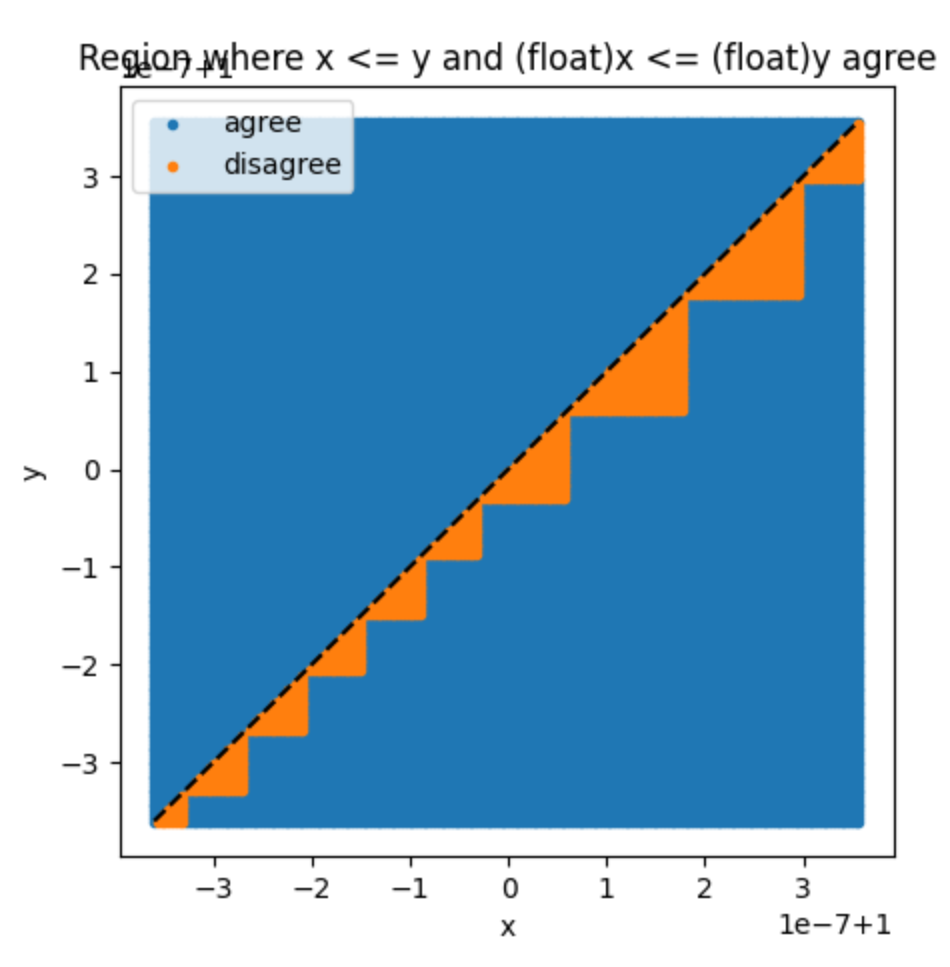

In [22]:
Image('images/double.png', width=400)

**Small discrepancies = distinct decision path**

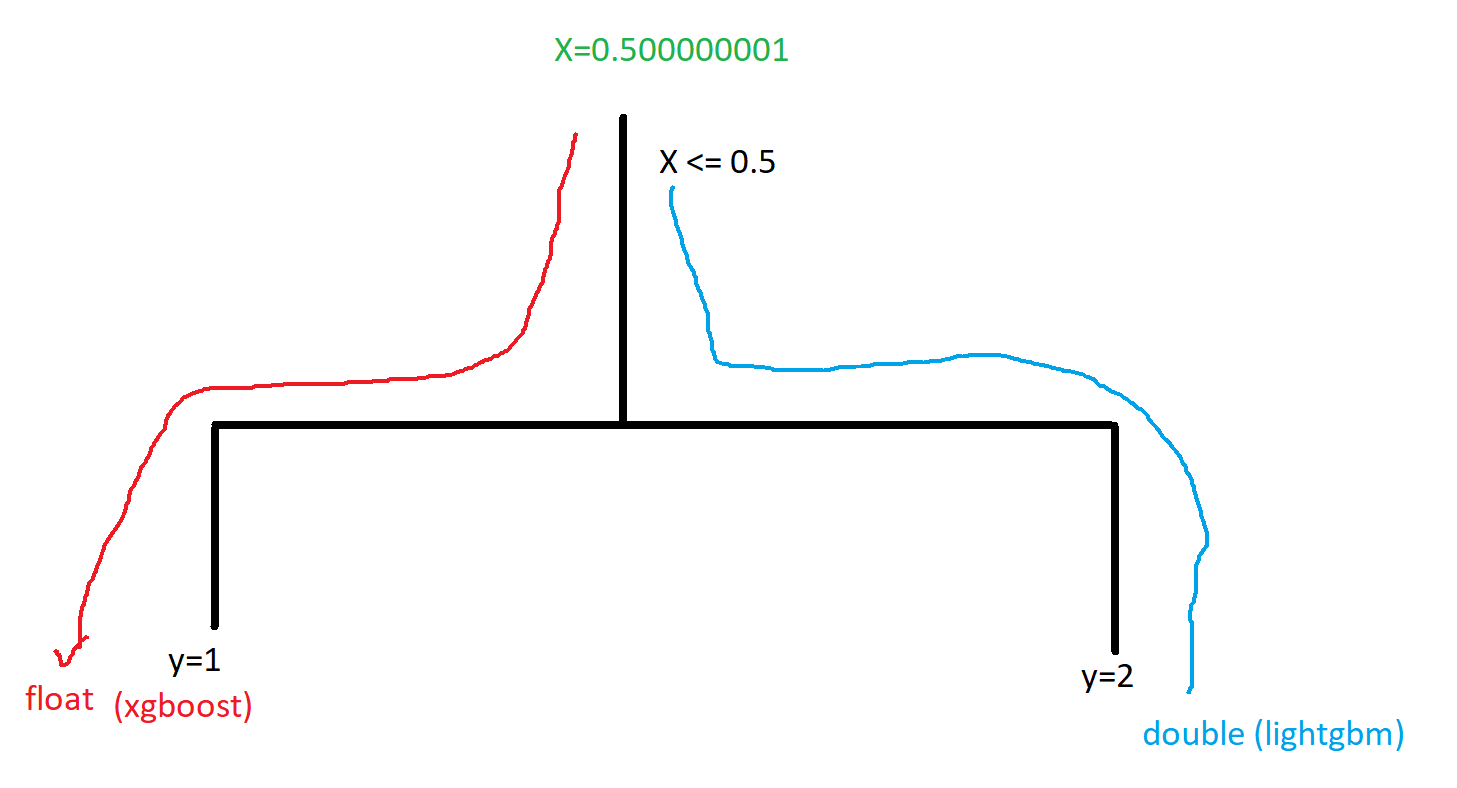

In [23]:
Image("images/stepwise.png", width=500)

**Solution:** compare onnx predictions with lightgbm predictions on **float features** only

**Small discrepencies = random walk for huge forest**

Huge forest = 50.000 trees

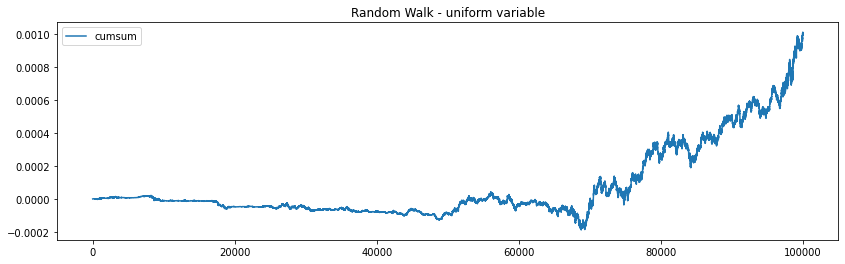

In [24]:
import pandas
rnd = numpy.abs(numpy.random.rand(100000)) - 0.5
c64, c32 = numpy.cumsum(rnd), numpy.cumsum(rnd.astype(numpy.float32))
diff = c64 - c32.astype(numpy.float64)
dfn = pandas.DataFrame(diff)
dfn.columns = ["cumsum"]
dfn.plot(logx=False, logy=False, title="Random Walk - uniform variable", figsize=(14, 4));

**Solution:** split the operator [TreeEnsembleRegressor](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.TreeEnsembleRegressor)

**Split the operator TreeEnsembleRegressor**, then cast the output in double and do the summation with double precision

Regression with 40.000, 200 features, trained with [lightgbm](https://lightgbm.readthedocs.io/en/latest/).

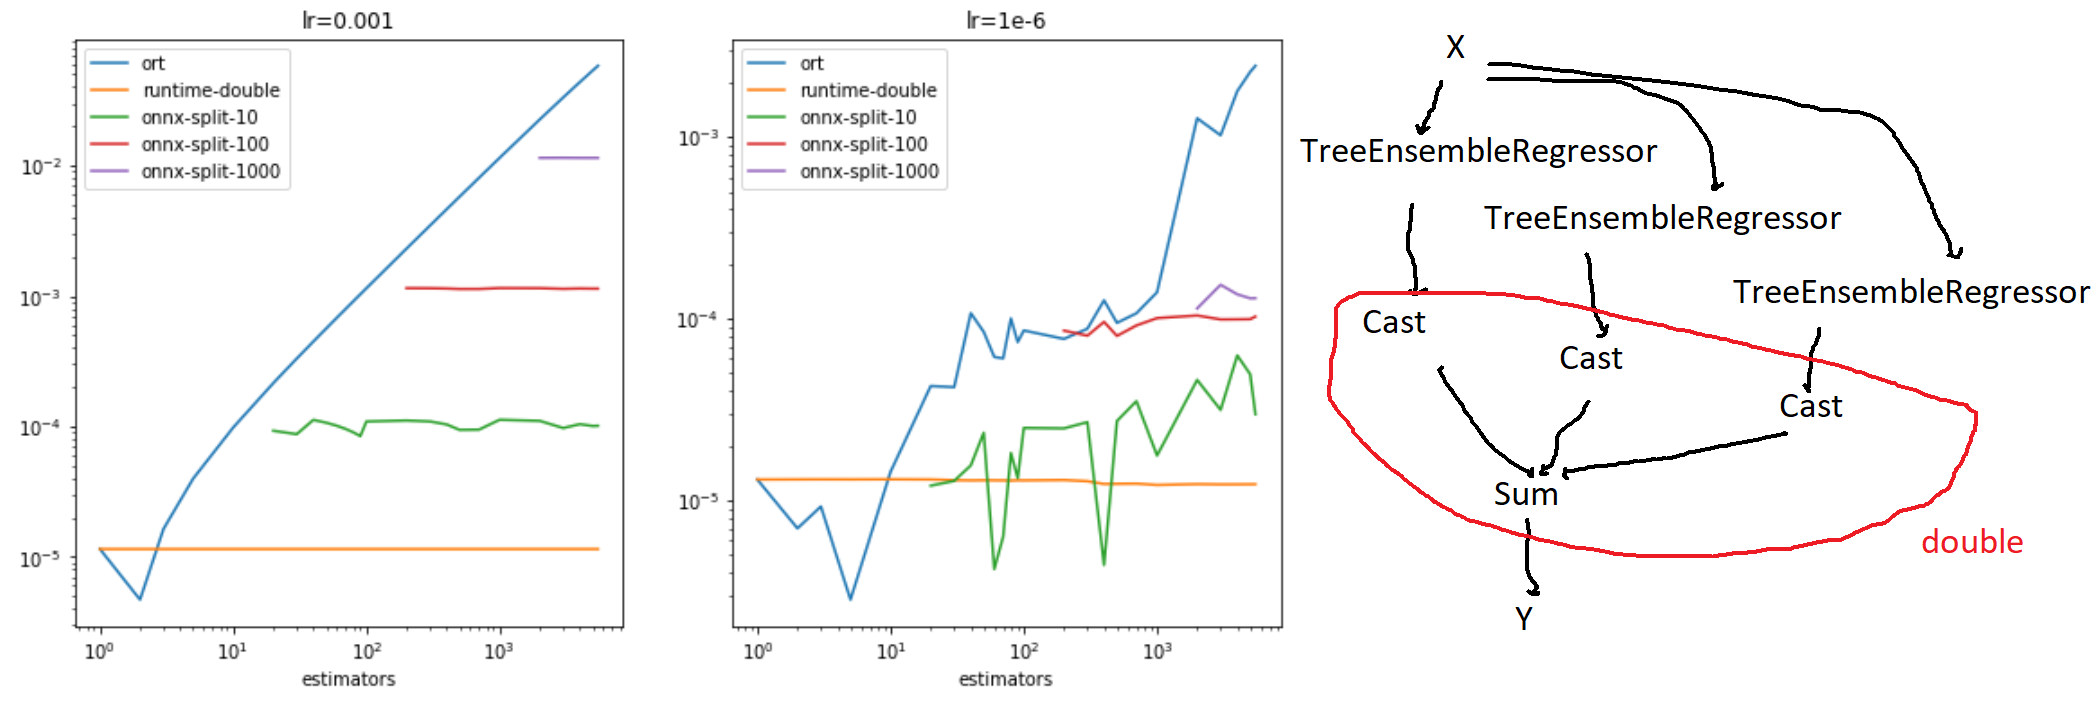

In [25]:
Image('images/treesplit.png')

### Sparse Story

ONNX: Incomplete sparse support

* explicit use of Sparse
    * [SparsePCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA)
    * [sparse_coef_](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet.sparse_coef_)
* Dense to Sparse
    * [OneHotEncoder(sparse=True)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
    * [TfIdfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
    
Once it is sparse, everything which follows must handle sparse as inputs:
    * linear models
    * ensemble

[Combine predictors using stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py)

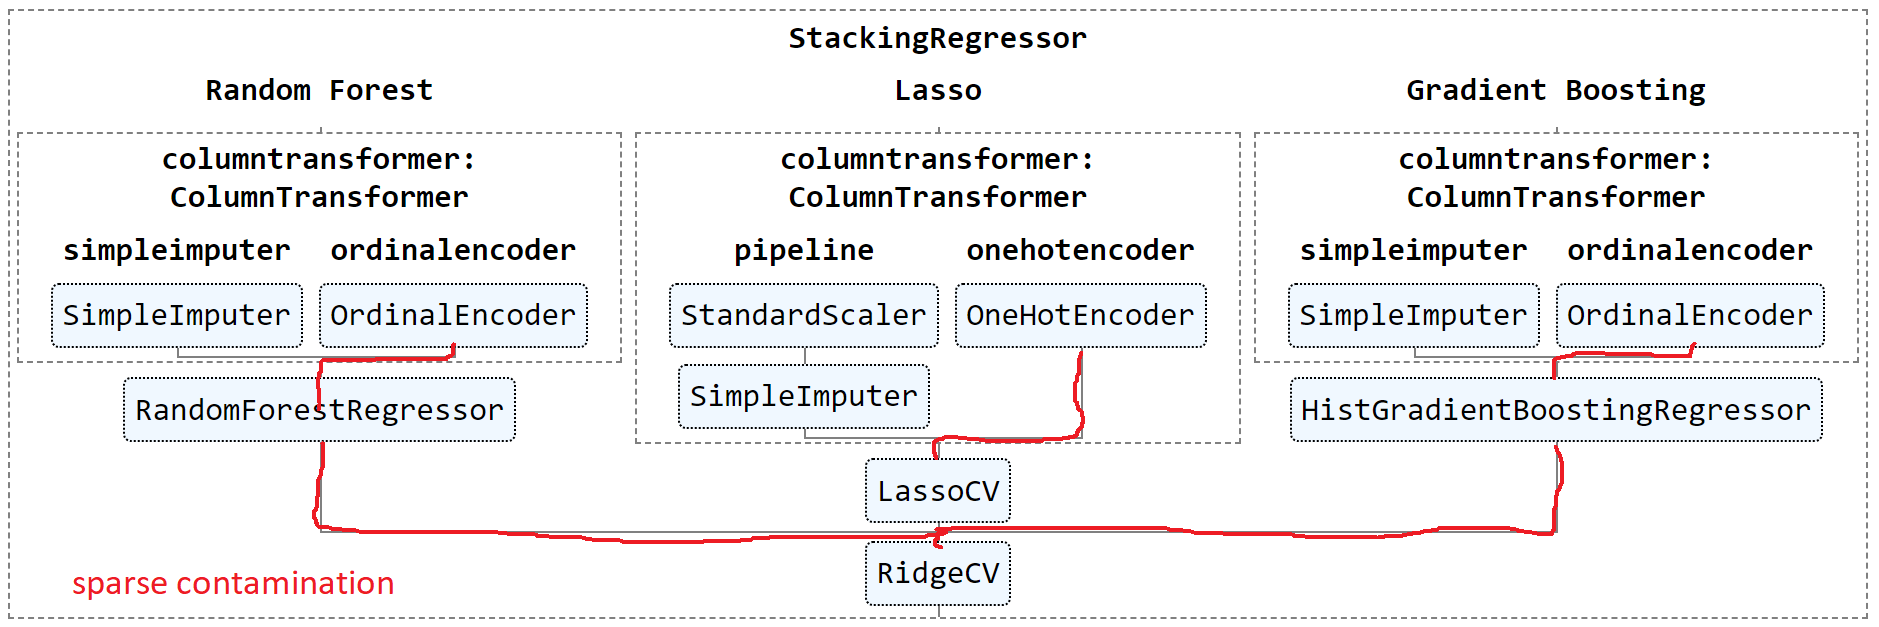

In [26]:
Image('images/pipedoc.png')

## Part 2 : Custom operators, 3 API, and custom code

* Guidelines to add a new converter
* Initial API: verbose
    * 2 years old
    * really verbose with estimators using estimators
    * options, opset
* Second API: much more readable
    * operators as functions
    * easier but still too complex
* Missing converter: [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)
* Numpy API: python users
    * Users don't want to write converters: too complex.
    * They only know [numpy](https://numpy.org/) and [pandas](https://pandas.pydata.org/).
* Main concerns or requests
    * Tools to check discrepancies
    * Benchmarks !

In [47]:
add_notebook_menu(first_level=2, keep_item=1)

### Guidelines to add a new converter

The best is probably to follow one past PR: [Add converter for KernelPCA](https://github.com/onnx/sklearn-onnx/pull/737).

### Why scikit-learn is more complex than tensorflow?

* [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)
* [Mixture Models](https://en.wikipedia.org/wiki/Mixture_model)

Formulas... do not always help.

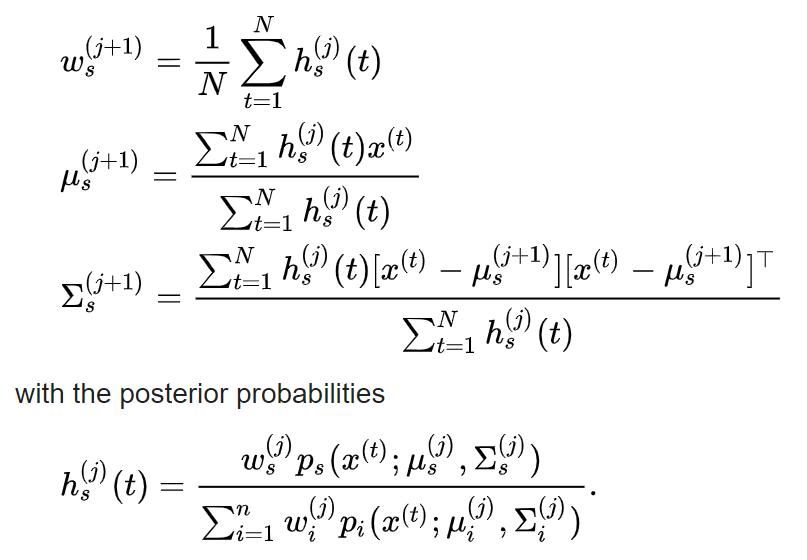

In [49]:
Image("images/gm.png", width=500)

The code is needed and it basically means converting numpy epxressions into ONNX.

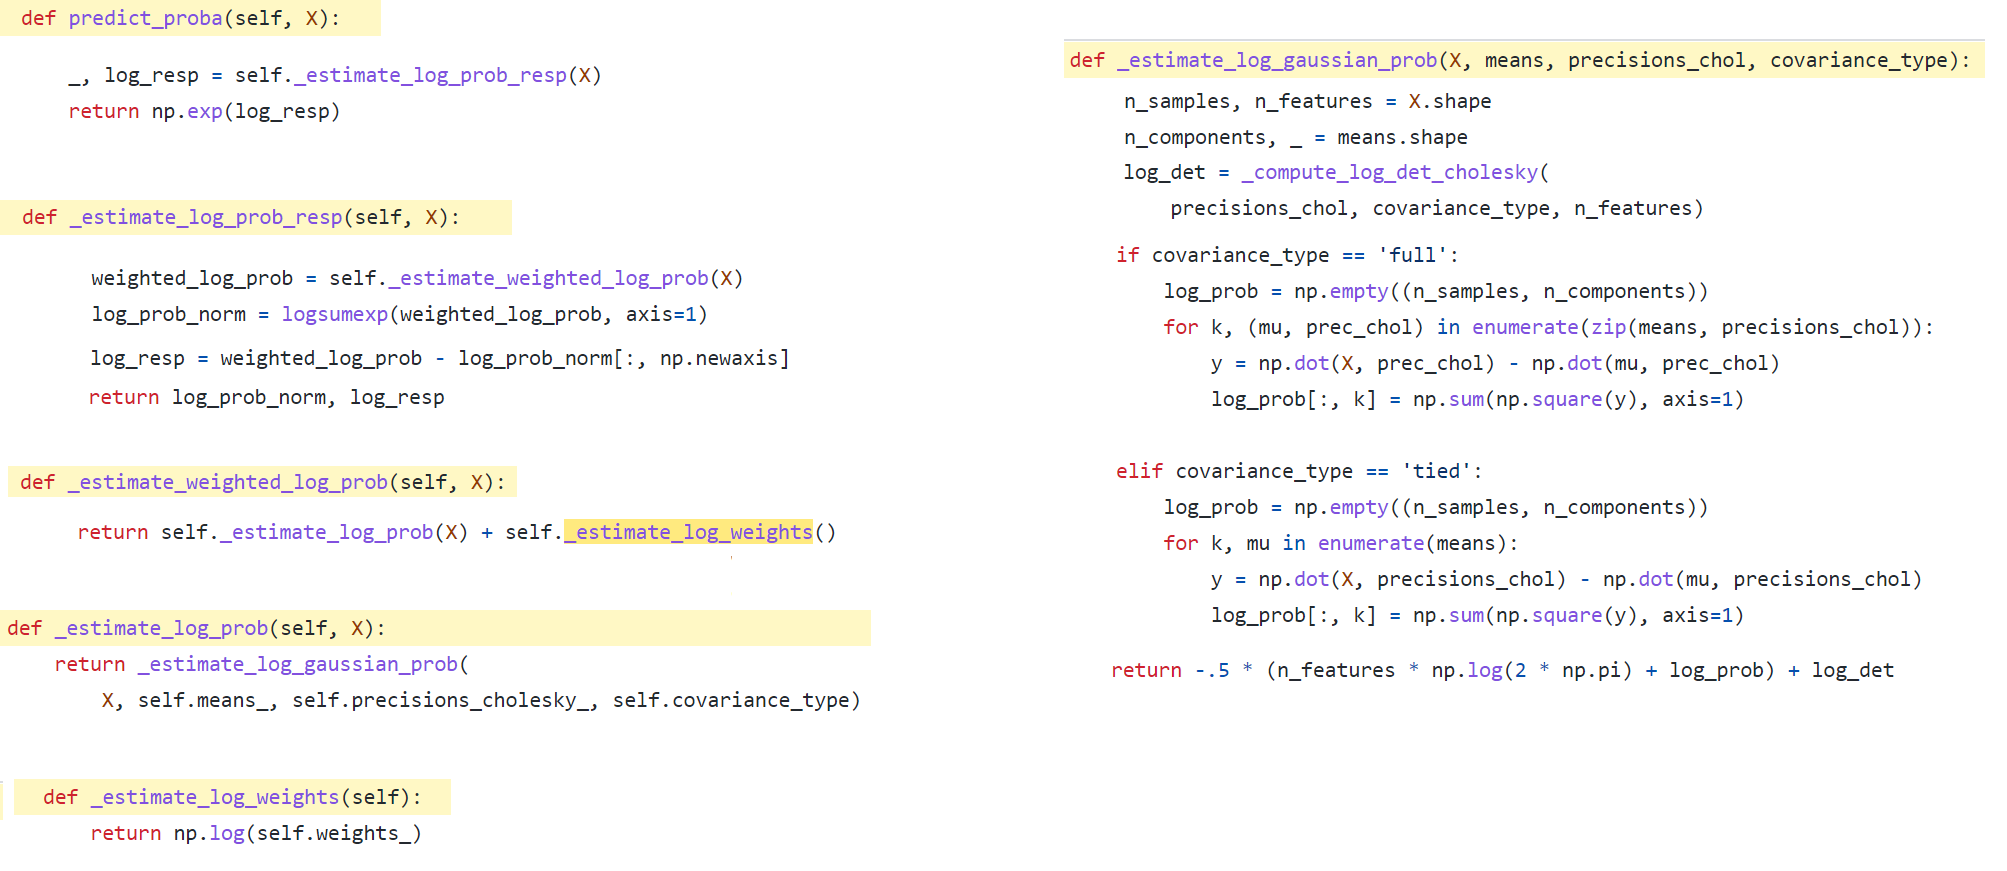

In [50]:
Image("images/codegm.png")

### First API: very close to ONNX API

Class [Container](https://github.com/onnx/sklearn-onnx/blob/master/skl2onnx/common/_container.py#L203).

``def add_initializer(self, name, onnx_type, shape, content):``

``def add_node(self, op_type, inputs, outputs, op_domain='', op_version=None, name=None, **attrs):``
 

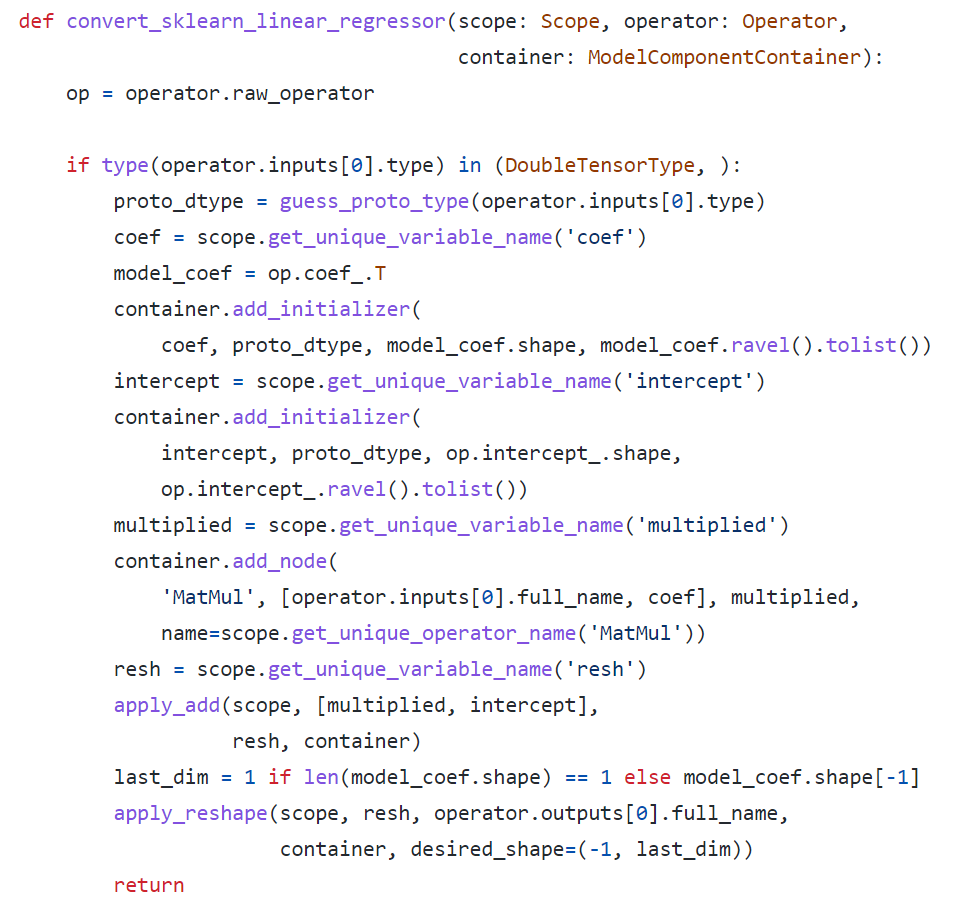

In [53]:
Image("images/linreg.png", width=500)